# Part 7.1 - Applying Regression
---

### Papers Past Topic Modeling
<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import sys, gc
sys.path.insert(0, '../utils')
from utils import conf_pyspark, load_dataset
from utils_preplot import load_doctopic
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')
sns.axes_style("darkgrid")
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from pyspark.sql import functions as F
from pyspark.sql.types import *

# intiate PySpark
sc, spark = conf_pyspark()

sc

[('spark.app.id', 'local-1548549361244'),
 ('spark.driver.host', 'x99.hub'),
 ('spark.app.name', 'local'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.memory', '62g'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.cores', '6'),
 ('spark.driver.port', '37111'),
 ('spark.driver.maxResultSize', '4g')]


<SparkContext master=local[*] appName=local>

**In this part we will apply linear regression on topic modeling result files to find with time goes there are correlations between topics or not.**

## 1 Load Data

**Load metadata:**

In [2]:
df_meta = load_dataset('meta', spark).select(F.col('id').alias('id_'), F.col('region'), F.col('date'))
df_meta.cache()

DataFrame[id_: int, region: string, date: date]

In [3]:
df_meta.limit(5).toPandas().head()

,id_,region,date
0,1854215,Auckland,1862-06-14
1,1854221,Auckland,1862-06-14
2,1854224,Auckland,1862-07-03
3,1854233,Auckland,1863-08-01
4,1854245,Auckland,1863-09-01


**Topic List:**

In [4]:
path = r'../models/train/topicKeys.txt'

df_topics = (pd.read_table(path, 
                           header=None, 
                           index_col=None, 
                           names = ['topic_', 'weight_', 'keywords_'],
                           encoding='utf8')
             .sort_values(by='topic_')
             .reset_index(drop=True))

topics_shape = df_topics.shape
topic_number = df_topics.shape[0]

In [5]:
print('Shape of dataframe:', topics_shape)
df_topics.sample(5)

Shape of dataframe: (200, 3)


,topic_,weight_,keywords_
10,10,0.00654,motor car cars good street model tyres ford motors garage order price sedan sale cycle saloon service condition phon...
182,182,0.00681,liver food column advertisements stomach health chemists emulsion indigestion blood cure bottle children tonic good ...
78,78,0.01095,man don't good time day asked boy young it's i'm back put sir replied make told dear thing give i'll
49,49,0.00503,hair skin ointment soap column advertisements cuticura face free chemists scalp treatment hands eczema cure piles bo...
61,61,0.00360,good fat sold prices sheep ewes cattle sale cows wethers medium prime lambs stock report store demand heifers market...


**Load doc-topic matrix:**

In [6]:
path = r'../models/train/docTopics.txt'

df_doctopic = (load_doctopic(path, topics_shape[0], spark)).drop('index').orderBy('id')
df_doctopic.cache();

In [7]:
print('Shape of dataframe:({}, {})'.format(df_doctopic.count(), len(df_doctopic.columns)))
df_doctopic.limit(5).toPandas().head()

Shape of dataframe:(1814086, 201)


,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1854215,0.000033,0.000132,0.000118,0.000131,0.000171,0.000668,0.000116,0.000187,0.000273,0.000064,0.000112,0.000099,0.000060,0.000059,0.000085,0.000147,0.000094,0.000080,0.000199,0.000119,0.000104,0.000062,0.000165,0.000138,0.000107,0.000165,0.000194,0.000101,0.017802,0.000194,0.000138,0.000077,0.000127,0.000134,0.000149,0.000070,0.000114,0.000213,0.000095,0.000208,0.000109,0.000036,0.000136,0.000133,0.000133,0.000115,0.000147,0.000116,0.000129,0.000086,0.000236,0.000124,0.000107,0.000105,0.000113,0.000115,0.000103,0.000175,0.000157,...,0.000030,0.000227,0.000114,0.000099,0.000075,0.000087,0.000079,0.000069,0.017168,0.000104,0.000114,0.000138,0.000066,0.000118,0.000102,0.000109,0.000042,0.000033,0.000024,0.000101,0.000105,0.000043,0.000095,0.000189,0.000315,0.000096,0.000114,0.000144,0.000021,0.000219,0.273583,0.000145,0.000116,0.000110,0.000030,0.000141,0.000284,0.000111,0.000225,0.000189,0.000117,0.000084,0.000116,0.000089,0.000220,0.000031,0.000224,0.000171,0.000076,0.000103,0.000158,0.000101,0.000052,0.000181,0.000127,0.000154,0.000169,0.000111,0.000106,0.000110
1,1854221,0.000047,0.000186,0.000166,0.000184,0.000240,0.000942,0.000163,0.000264,0.000384,0.000090,0.000158,0.000140,0.000085,0.000083,0.000120,0.000207,0.000133,0.000113,0.000280,0.000167,0.000146,0.000088,0.000233,0.000194,0.000151,0.000232,0.000274,0.000142,0.025093,0.000273,0.000194,0.000109,0.000179,0.000190,0.000210,0.000099,0.000160,0.000300,0.000134,0.000293,0.000154,0.000050,0.000191,0.000187,0.000187,0.000162,0.000207,0.000164,0.000182,0.000121,0.000333,0.000175,0.000151,0.000147,0.000159,0.000162,0.000145,0.000246,0.000221,...,0.000042,0.000320,0.000161,0.000139,0.000106,0.000122,0.000112,0.000098,0.000108,0.000147,0.000161,0.000194,0.000092,0.000167,0.000143,0.000154,0.000059,0.000047,0.000034,0.000142,0.000148,0.000060,0.000134,0.000266,0.000443,0.000135,0.000160,0.000203,0.000029,0.000309,0.000164,0.000205,0.000163,0.915641,0.000042,0.000199,0.000401,0.000156,0.000318,0.000266,0.000166,0.000118,0.000164,0.000125,0.000310,0.000043,0.000316,0.000241,0.000107,0.000145,0.000223,0.000143,0.000074,0.000255,0.000179,0.000218,0.000238,0.000157,0.000150,0.000155
2,1854224,0.000044,0.000174,0.000155,0.067575,0.000224,0.000878,0.000152,0.000246,0.000358,0.000084,0.000147,0.000131,0.000079,0.000077,0.000112,0.000193,0.000124,0.000106,0.000261,0.000156,0.000137,0.000082,0.000217,0.000181,0.000141,0.000216,0.000256,0.000133,0.000934,0.000255,0.000181,0.000102,0.000167,0.000177,0.000196,0.000092,0.000150,0.000280,0.000125,0.000273,0.000143,0.000047,0.000179,0.000175,0.000175,0.000151,0.000193,0.000153,0.000169,0.000113,0.000311,0.000163,0.000141,0.000137,0.000148,0.000151,0.000135,0.000230,0.000206,...,0.000039,0.000299,0.000150,0.000130,0.000099,0.000114,0.000104,0.000091,0.000100,0.000137,0.000150,0.000181,0.000086,0.000155,0.000133,0.000143,0.000055,0.000044,0.000032,0.000133,0.000138,0.000056,0.000125,0.000248,0.000414,0.000126,0.000149,0.000189,0.000027,0.000288,0.000153,0.000191,0.000152,0.876392,0.000040,0.000185,0.000374,0.000145,0.000296,0.000248,0.000154,0.000111,0.000153,0.000117,0.000290,0.000040,0.000295,0.000225,0.000100,0.000136,0.000208,0.000133,0.000069,0.000238,0.000167,0.000203,0.000222,0.000146,0.000140,0.000145
3,1854233,0.000013,0.000053,0.000047,0.000052,0.000068,0.000267,0.000046,0.000075,0.409643,0.102409,0.000045,0.000040,0.000024,0.000024,0.000034,0.000059,0.000038,0.000032,0.000079,0.000047,0.000041,0.081932,0.000066,0.034183,0.000043,0.000066,0.000078,0.000040,0.000284,0.000077,0.000055,0.000031,0.000051,0.000054,0.000060,0.000

## 2 Generate Dataset

**The result files of MALLET can not be used to regress directly, we need to generate a dataset for regressiong. The dataset consists of all topics, the weight of each topic is a feature, each observor/sample/row is a time unit. To sample more observor, we take month as the time unit.**

**Generate average weight-month matrix:**

In [8]:
# doc-weight-month matrix
df = (df_doctopic
      .join(df_meta, df_doctopic.id == df_meta.id_)
      .withColumn('time', F.date_format('date', 'yyyy-MM'))
      .drop('id')
      .drop('id_')
      .drop('region')
      .drop('date')
      .orderBy('time')
      )

df.limit(5).toPandas().head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,...,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,time
0,0.000007,0.000026,0.000023,0.000026,0.000034,0.000133,0.000023,0.000037,0.163038,0.000013,0.000022,0.000020,0.000012,0.000012,0.000017,0.000029,0.000019,0.000016,0.000039,0.000024,0.000021,0.000012,0.000033,0.000027,0.000021,0.000033,0.000039,0.000020,0.000141,0.013620,0.006818,0.000015,0.000025,0.000027,0.000030,0.000014,0.000023,0.000042,0.000019,0.000041,0.000022,0.000007,0.000027,0.000026,0.000026,0.000023,0.000029,0.000023,0.000026,0.000017,0.000047,0.000025,0.000021,0.000021,0.207147,0.000023,0.000020,0.000035,0.000031,0.000020,...,0.000045,0.000023,0.000020,0.000015,0.000017,0.000016,0.000014,0.000015,0.000021,0.000023,0.000027,0.000013,0.000023,0.000020,0.000022,0.000008,0.000007,0.000005,0.000020,0.000021,0.000009,0.000019,0.000037,0.000062,0.000019,0.000023,0.000029,0.000004,0.000044,0.000023,0.000029,0.000023,0.000022,0.000006,0.000028,0.000056,0.000022,0.000045,0.000038,0.000023,0.000017,0.000023,0.000018,0.000044,0.000006,0.000045,0.000034,0.000015,0.000020,0.000031,0.112071,0.000010,0.000036,0.000025,0.000031,0.000033,0.000022,0.000021,0.000022,1839-08
1,0.000005,0.000019,0.000017,0.000018,0.000024,0.000094,0.000016,0.000026,0.000038,0.000009,0.000016,0.000014,0.000009,0.000008,0.000012,0.000021,0.000013,0.000011,0.000028,0.000017,0.000015,0.000009,0.000023,0.000019,0.000015,0.000023,0.000027,0.000014,0.000100,0.000027,0.000019,0.000011,0.000018,0.000019,0.000021,0.000010,0.000016,0.000030,0.000013,0.000029,0.000015,0.000005,0.000019,0.000019,0.000019,0.000016,0.000021,0.036204,0.000018,0.000012,0.000033,0.000018,0.000015,0.000015,0.062741,0.000016,0.463214,0.000025,0.000022,0.000014,...,0.000032,0.000016,0.000014,0.000011,0.000012,0.000011,0.000010,0.000011,0.000015,0.000016,0.000019,0.000009,0.000017,0.000014,0.000015,0.000006,0.000005,0.000003,0.000014,0.000015,0.000006,0.000013,0.000027,0.000044,0.000014,0.000016,0.000020,0.000003,0.000031,0.000016,0.000020,0.000016,0.000016,0.000004,0.000020,0.026578,0.000016,0.000032,0.000027,0.000017,0.000012,0.000016,0.000013,0.000031,0.000004,0.000032,0.000024,0.000011,0.000015,0.000022,0.000014,0.000007,0.002438,0.000018,0.000022,0.000024,0.000016,0.284690,0.033790,1839-08
2,0.000007,0.000027,0.000024,0.000027,0.000035,0.000138,0.000024,0.000039,0.000056,0.000013,0.000023,0.000021,0.010594,0.000012,0.067035,0.000030,0.000019,0.000017,0.000041,0.000024,0.000021,0.000013,0.000034,0.000028,0.000022,0.000034,0.000040,0.000021,0.000147,0.000040,0.000028,0.000016,0.000026,0.000028,0.000031,0.000014,0.000023,0.000044,0.000020,0.000043,0.000022,0.000007,0.000028,0.000027,0.000027,0.000024,0.112902,0.000024,0.000027,0.000018,0.000049,0.000026,0.000022,0.000022,0.144640,0.000024,0.000021,0.000036,0.000032,0.000021,...,0.000047,0.000024,0.000020,0.000016,0.000018,0.000016,0.000014,0.000016,0.000022,0.000024,0.000028,0.000014,0.000024,0.003548,0.000022,0.000009,0.000007,0.000005,0.000021,0.000022,0.000009,0.000020,0.000039,0.000065,0.000020,0.000023,0.000030,0.000004,0.000045,0.000024,0.000030,0.024715,0.000023,0.000006,0.000029,0.000059,0.000023,0.000047,0.000039,0.000024,0.000017,0.000024,0.000018,0.000045,0.000006,0.000046,0.000035,0.000016,0.000021,0.000033,0.000021,0.000011,0.000037,0.000026,0.000032,0.000035,0.000023,0.000022,0.000023,1840-04
3,0.000013,0.000050,0.000045,0.000050,0.000065,0.000255,0.000044,0.000071,0.000104,0.000024,0.000043,0.000038,0.000023,0.000022,0.000032,0.000056,0.000036,0.000031,0.000076,0.000045,0.000040,0.000024,0.000063,0.000052,0.000041,0.000063,0.000074,0.000039,0.000271,0.000074,0.000052,0.000030,0.000048,0.000051,0.000057,0.000027,0.0

In [9]:
# avg-weight-month matrix
df = (df
      .groupBy('time')
      .avg()
      .orderBy('time'))

df = df.toPandas()

columns = [str(x) for x in list(range(topic_number))]
columns.insert(0, 'time')
df.columns = columns

print('Shape of dataframe:', df.shape)
df.head()

Shape of dataframe: (1234, 201)


,time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1839-08,0.000006,0.000022,0.000020,0.000022,0.000029,0.000113,0.000020,0.000032,0.081538,0.000011,0.000019,0.000017,0.000010,0.000010,0.000014,0.000025,0.000016,0.000014,0.000034,0.000020,0.000018,0.000011,0.000028,0.000023,0.000018,0.000028,0.000033,0.000017,0.000121,0.006824,0.003419,0.000013,0.000022,0.000023,0.000025,0.000012,0.000019,0.000036,0.000016,0.000035,0.000019,0.000006,0.000023,0.000023,0.000023,0.000019,0.000025,0.018114,0.000022,0.000015,0.000040,0.000021,0.000018,0.000018,0.134944,0.000019,0.231617,0.000030,0.000027,...,0.000005,0.000039,0.000019,0.000017,0.000013,0.000015,0.000013,0.000012,0.000013,0.000018,0.000019,0.000023,0.000011,0.000020,0.000017,0.000019,0.000007,0.000006,0.000004,0.000017,0.000018,0.000007,0.000016,0.000032,0.000053,0.000016,0.000019,0.000024,0.000004,0.000037,0.000020,0.000025,0.000020,0.000019,0.000005,0.000024,0.013317,0.000019,0.000038,0.000032,0.000020,0.000014,0.000020,0.000015,0.000037,0.000005,0.000038,0.000029,0.000013,0.000018,0.000027,0.056043,0.000009,0.001237,0.000022,0.000026,0.000029,0.000019,0.142356,0.016906
1,1840-04,0.000013,0.000051,0.000045,0.000050,0.000066,0.000258,0.000045,0.000072,0.030059,0.000025,0.000043,0.000038,0.001787,0.009546,0.011202,0.000057,0.001052,0.059212,0.000943,0.000046,0.000040,0.000024,0.000064,0.000053,0.000041,0.000064,0.000075,0.000039,0.002813,0.000075,0.000053,0.000030,0.000049,0.000052,0.000058,0.000027,0.000044,0.000082,0.052151,0.032289,0.000042,0.000014,0.000052,0.000051,0.002812,0.006255,0.053612,0.022185,0.000050,0.000033,0.000091,0.000048,0.000041,0.000040,0.102816,0.000044,0.060643,0.003114,0.000060,...,0.000011,0.056154,0.000044,0.000038,0.000029,0.000033,0.000031,0.000027,0.000029,0.000040,0.000044,0.000053,0.000025,0.000046,0.000627,0.000042,0.000016,0.000013,0.000009,0.000039,0.023926,0.000017,0.000037,0.000073,0.000121,0.000037,0.000044,0.000056,0.000008,0.000085,0.047662,0.001788,0.011268,0.000043,0.000012,0.000054,0.000110,0.000043,0.000087,0.012141,0.000045,0.000032,0.001425,0.000034,0.000085,0.000012,0.006433,0.000066,0.004358,0.000040,0.000061,0.000039,0.000020,0.000070,0.010874,0.000060,0.000065,0.000043,0.000041,0.000042
2,1840-05,0.000019,0.000076,0.003367,0.000075,0.001304,0.000383,0.000307,0.000107,0.058032,0.005379,0.000064,0.000057,0.000035,0.000034,0.003459,0.000084,0.000054,0.000046,0.000114,0.000068,0.000059,0.000036,0.000095,0.000079,0.000061,0.001841,0.023198,0.000058,0.000675,0.017384,0.000079,0.000044,0.003285,0.001533,0.000085,0.003446,0.000065,0.000122,0.009482,0.000119,0.000062,0.000020,0.000078,0.000613,0.000076,0.008795,0.011628,0.004451,0.000074,0.000049,0.000135,0.025518,0.000061,0.000060,0.099732,0.000066,0.040600,0.011551,0.001164,...,0.000017,0.000130,0.000066,0.000057,0.000043,0.000050,0.000045,0.000040,0.000044,0.000060,0.005791,0.001685,0.000038,0.000068,0.003436,0.000062,0.000024,0.000019,0.000014,0.000058,0.000060,0.000025,0.001122,0.000108,0.010513,0.000055,0.000065,0.000082,0.000012,0.000126,0.093899,0.000083,0.000066,0.000063,0.000741,0.000081,0.022555,0.000063,0.000129,0.005898,0.002501,0.000048,0.000067,0.000051,0.000126,0.000018,0.000128,0.002047,0.000043,0.005662,0.000090,0.017460,0.054560,0.000104,0.000073,0.012108,0.000097,0.000064,0.008343,0.005666
3,1840-06,0.000028,0.000112,0.002647,0.000110,0.000144,0.015850,0.000098,0.000158,0.018227,0.008762,0.000095,0.000674,0.000051,0.000050,0.052621,0.000124,0.000080,0.000068,0.000168,0.000100,0.000088,0.000053,0.000140,0.008356,0.000091,0.000139,0.000165,0.000086,0.123907,0.026980,0.000116,0.000066,0.000107,0.000114,0.005838,0.0

## 3 Plot Dataset

**Plot month base dataframe will take too much time, we resample dataframe to year base to plot faster.**

In [10]:
# resampling to year
df_plt = (df_doctopic
          .join(df_meta, df_doctopic.id == df_meta.id_)
          .withColumn('year', F.date_format('date', 'yyyy'))
          .drop('id')
          .drop('id_')
          .drop('region')
          .drop('date')
          .groupBy('year')
          .avg()
          .orderBy('year')
          .toPandas())

columns = [str(x) for x in list(range(topic_number))]
columns.insert(0, 'year')
df_plt.columns = columns

# melt for plot
df_plt = pd.melt(df_plt,
                 id_vars='year',
                 value_vars=list(df.columns[1:]),
                 var_name='topic',
                 value_name='weight')

# change data type
df_plt.topic = df_plt.topic.astype(int)

# join
df_plt = (df_plt
          .merge(df_topics, left_on='topic', right_on='topic_')
          .drop('topic_', axis=1)
          .drop('weight_', axis=1)
          .drop('keywords_', axis=1)
          .sort_values(by=['year', 'topic'])
          .reset_index(drop=True))

# change columns name
df_topics.columns = ['topic', 'weight', 'keywords']

print('Shape of dataframe', df_plt.shape)
df_plt.sample(5)

Shape of dataframe (20800, 3)


,year,topic,weight
12608,1902,8,0.006145
2387,1850,187,0.005120
19782,1940,182,0.003420
11834,1898,34,0.014461
6510,1871,110,0.003756


**Plot each feature to check trends:**

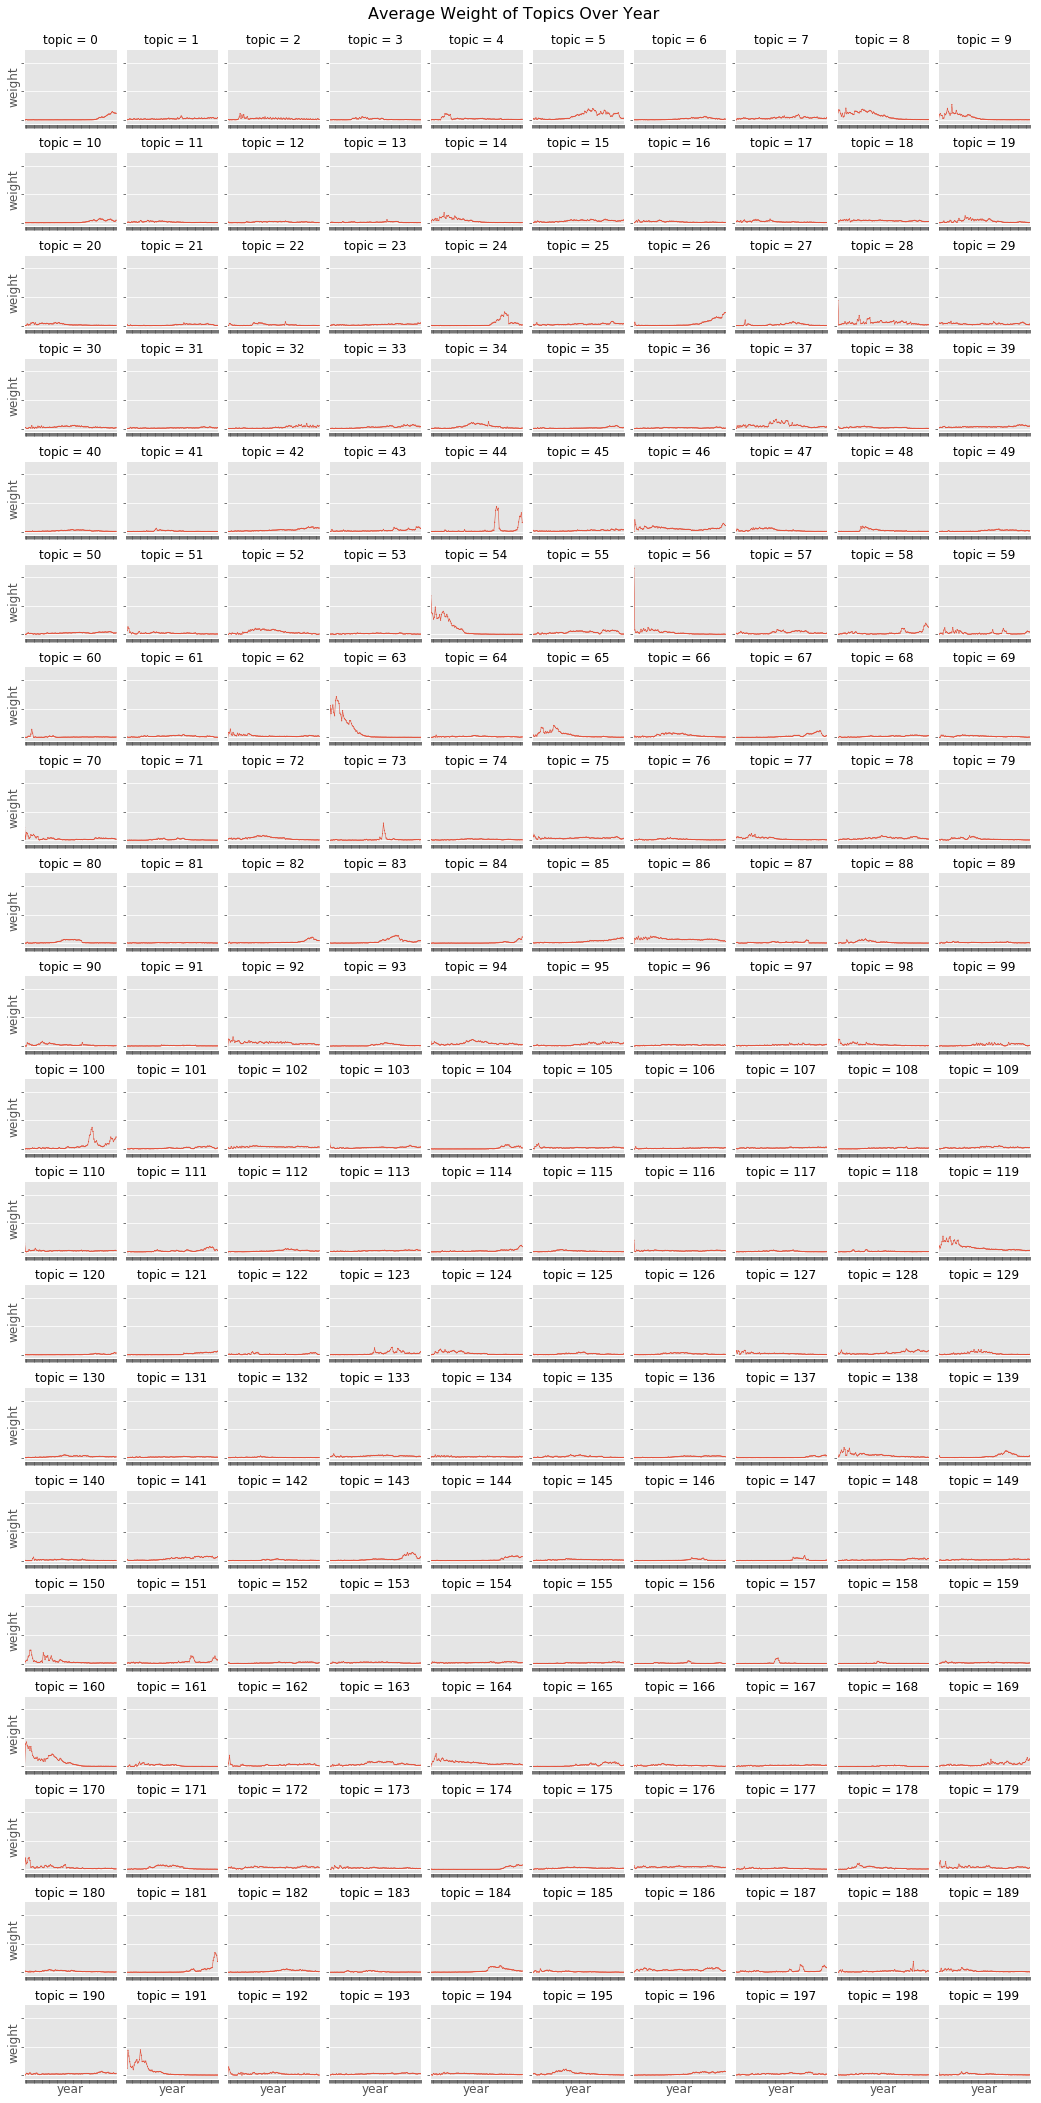

In [11]:
#plot
g = sns.catplot(x="year", y='weight',  col='topic', col_wrap=10, 
                kind='point', height=1.5, aspect=1, dodge=False, s=0.2, legend=False, 
                markers='.', scale=0.2,
                data=df_plt)
g.fig.suptitle("Average Weight of Topics Over Year", fontsize=16)
g.set_xticklabels(visible=False)
g.set_yticklabels(visible=False)
g.fig.subplots_adjust(top=0.96, hspace=0.4, wspace=0.1)

## 4 Search Correlation

**After we get weight-month matrix, we check the correlation among features:**

In [12]:
# remove time for regression
df.drop(columns='time')

# Compute pairwise correlation of Dataframe's attributes
corr = df.corr()
corr

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1.000000,0.283290,-0.147022,-0.292375,-0.235908,0.055639,0.068717,-0.050347,-0.427813,-0.286513,0.599214,-0.336620,-0.164194,-0.310932,-0.337279,0.108319,-0.243404,-0.278501,-0.207093,-0.327471,-0.315006,0.151450,-0.286841,0.427612,0.213702,0.304239,0.862040,-0.267234,-0.289117,0.013359,-0.190405,0.230549,0.361011,0.516186,-0.341851,0.543894,0.180696,-0.293048,-0.382265,0.462245,-0.335400,-0.240006,0.536241,0.592098,0.284597,0.474479,0.226771,-0.380146,-0.262968,0.086166,0.368568,-0.214112,-0.402545,-0.284082,-0.278302,0.035855,-0.254939,-0.167960,0.667092,-0.018545,...,-0.184109,0.432643,-0.160158,0.638163,0.649583,-0.146388,-0.167938,-0.141725,0.549844,0.283120,-0.236253,0.435014,0.206409,-0.319996,0.177407,0.475703,-0.032605,-0.147880,-0.147658,-0.174516,-0.292633,-0.325448,0.072560,-0.240781,-0.279367,0.274218,-0.335287,0.226082,-0.278109,0.505513,-0.189422,-0.355859,0.082474,-0.147257,0.895290,-0.085937,-0.042247,-0.342063,-0.345786,-0.055228,-0.406954,0.818376,0.034425,-0.225633,0.104660,-0.195668,0.112184,0.440708,0.218759,-0.258916,0.316784,-0.254757,-0.159627,0.196474,-0.318898,-0.392493,0.580502,-0.027390,-0.200876,-0.332067
1,0.283290,1.000000,-0.091489,-0.160209,-0.150143,0.340501,0.251154,0.195252,-0.357303,-0.321643,0.292785,-0.233947,0.089258,0.043398,-0.334909,0.215249,-0.233148,-0.194440,-0.028690,-0.137442,-0.257427,0.274778,-0.068949,0.269456,0.183226,0.148906,0.315507,0.136696,-0.122826,0.262128,-0.113361,0.136443,0.256920,0.412074,0.052354,0.273875,0.176418,-0.010503,-0.234054,0.182299,0.150451,-0.108726,0.260335,0.284692,0.071165,0.268975,-0.056662,-0.283343,-0.136308,0.311689,0.330545,-0.155404,-0.153516,-0.033741,-0.303334,0.162930,-0.275073,0.101171,0.206271,0.005851,...,-0.086883,0.368430,0.159043,0.321028,0.223073,0.039944,0.198305,0.142771,0.247263,0.096804,-0.205205,0.184829,0.232560,-0.142490,0.161136,0.348915,0.253703,-0.000167,-0.015954,-0.054540,-0.318473,-0.232477,0.003654,0.141158,-0.269868,0.217655,-0.177134,0.229091,0.184635,0.276006,-0.207581,-0.070409,0.023939,-0.039476,0.273812,0.094766,0.089505,-0.159611,-0.209647,-0.157858,-0.187691,0.199928,0.345103,-0.039230,0.246146,-0.124121,0.111476,0.217598,0.142682,-0.216801,0.151973,-0.299353,-0.129663,0.237225,-0.211950,-0.190488,0.331610,0.202484,-0.098304,-0.128891
2,-0.147022,-0.091489,1.000000,0.092649,0.402843,-0.109532,-0.101203,-0.083304,0.131806,0.107981,-0.164737,0.142017,0.033188,0.033044,0.172447,-0.075284,0.120620,0.032819,0.064312,0.122908,0.059322,-0.145295,0.012977,-0.175400,-0.114582,-0.069303,-0.174611,-0.001987,0.016783,-0.044496,-0.010694,-0.077063,0.023512,-0.158640,0.066914,-0.152525,-0.013304,0.088222,0.096320,-0.127531,0.066933,0.084179,-0.068164,-0.145509,-0.098510,-0.132319,0.035052,0.140920,0.071320,-0.114042,-0.137705,0.011676,0.099194,0.024412,0.121017,-0.044202,0.114642,-0.059146,-0.104856,0.047578,...,0.076436,-0.152816,0.047128,-0.139809,-0.110295,0.071840,-0.052686,-0.064824,-0.131259,-0.066644,-0.032231,-0.131726,-0.065431,0.128435,-0.133382,-0.088982,-0.007626,0.063892,0.063596,-0.026158,-0.002190,0.191817,-0.080378,-0.006033,0.093886,-0.134405,0.075021,-0.021236,0.004894,-0.139711,-0.037931,0.140643,-0.080162,0.011095,-0.157181,0.072849,0.003413,0.134649,0.155707,-0.063996,0.130598,-0.129614,-0.097622,0.174758,-0.106487,0.181539,-0.034778,-0.132486,-0.074994,0.013835,-0.124266,0.137114,-0.005000,-0.091055,0.253650,0.093042,-0.166766,-0.040013,0.071620,0.075479
3,-0.292375,-0.160209,0.092649,1.000000,-0.039763,-0.154212,-0.211709,-0.038605,0.348998,-0.035662,-0.380801,0.372255,0.349682,0.025257,0.0841

**Plot heatmap:**

Text(0.5, 0.98, 'Topic Weight Correlation Heatmap')

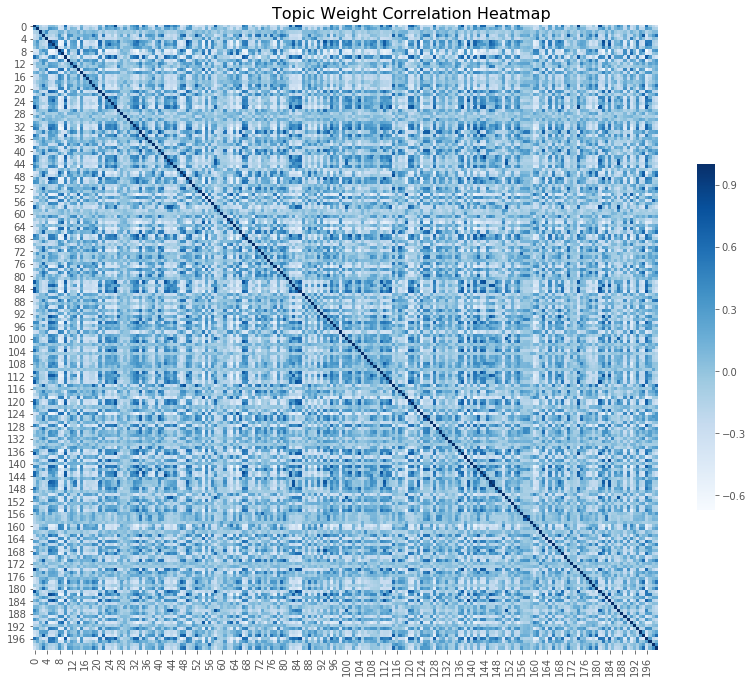

In [13]:
fig, (ax) = plt.subplots(1, 1, figsize=(14,11))

g = sns.heatmap(corr, 
                ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                cmap=plt.cm.Blues, # Color Map.
                cbar=True,
                cbar_kws={"shrink": .5},
                square=True,     # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                annot=False 
                #fmt='.2f',       # String formatting code to use when adding annotations.
                #annot_kws={"size": 14},
                #linewidths=.05
               )

fig.subplots_adjust(top=1)
fig.suptitle('Topic Weight Correlation Heatmap', 
              fontsize=16) 

**List the highest positive 10 correlation pairs:**

In [14]:
df_corr = df.corr().unstack().sort_values(kind='quicksort', ascending=False)
df_corr_p = pd.DataFrame(df_corr[200:210]).reset_index()
df_corr_p.columns = ['pair1', 'pair2', 'corr']
df_corr_p.T

,0,1,2,3,4,5,6,7,8,9
pair1,0,174,26,174,147,146,26,0,139,184
pair2,174,0,174,26,146,147,0,26,184,139
corr,0.89529,0.89529,0.878727,0.878727,0.876052,0.876052,0.86204,0.86204,0.844357,0.844357


In [15]:
topic_list = list(set(df_corr_p.pair1.unique()).union(set(df_corr_p.pair2.unique())))

print('The highest {} correlated topics: {}'.format(len(topic_list), topic_list))

The highest 7 correlated topics: ['26', '0', '184', '139', '147', '146', '174']


**Plot pairwise plots:**

Text(0.5, 0.98, 'Topic Pairwise Plots')

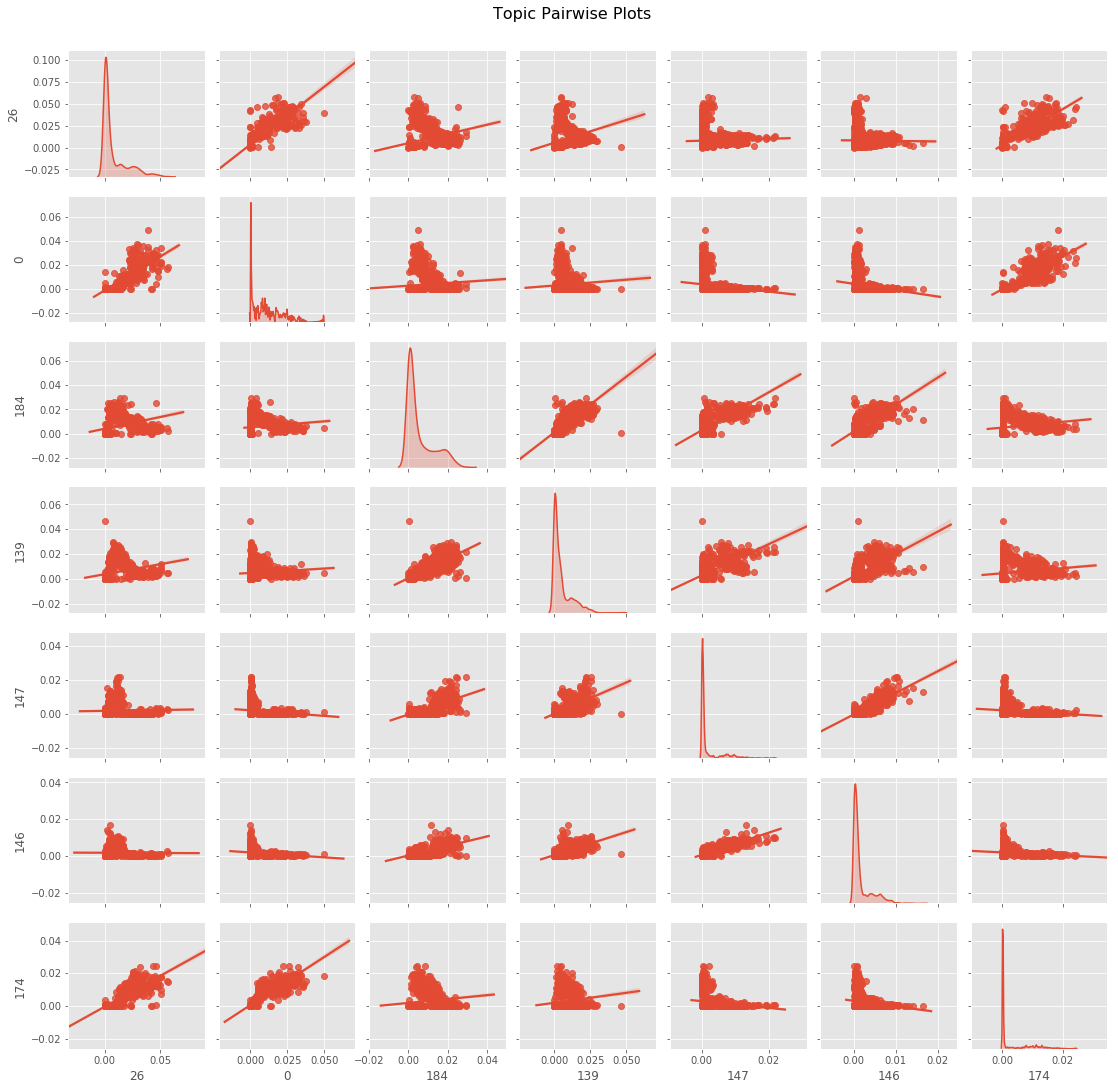

In [16]:
g = sns.pairplot(df[topic_list], 
                 diag_kws=dict(shade=True), # "diag" adjusts/tunes the diagonal plots
                 diag_kind="kde",           # use "kde" for diagonal plots
                 height=2.2,
                 aspect=1,
                 kind="reg")                # linear regression to the scatter plots

fig = g.fig 
fig.subplots_adjust(top=0.94, wspace=0.1)
fig.suptitle('Topic Pairwise Plots', fontsize=16)

**List the highest negative 10 correlation pairs:**

In [17]:
df_corr = df.corr().unstack().sort_values(kind='quicksort', ascending=True)
df_corr_n = pd.DataFrame(df_corr[:10]).reset_index()
df_corr_n.columns = ['pair1', 'pair2', 'corr']
df_corr_n.T

,0,1,2,3,4,5,6,7,8,9
pair1,8,196,8,141,85,8,95,8,33,8
pair2,196,8,141,8,8,85,8,95,8,33
corr,-0.672759,-0.672759,-0.664333,-0.664333,-0.664263,-0.664263,-0.6565,-0.6565,-0.640554,-0.640554


In [18]:
topic_list = list(set(df_corr_n.pair1.unique()).union(set(df_corr_n.pair2.unique())))

print('The highest {} correlated topics: {}'.format(len(topic_list), topic_list))

The highest 6 correlated topics: ['95', '8', '141', '85', '33', '196']


**Plot pairwise plots:**

Text(0.5, 0.98, 'Topic Pairwise Plots')

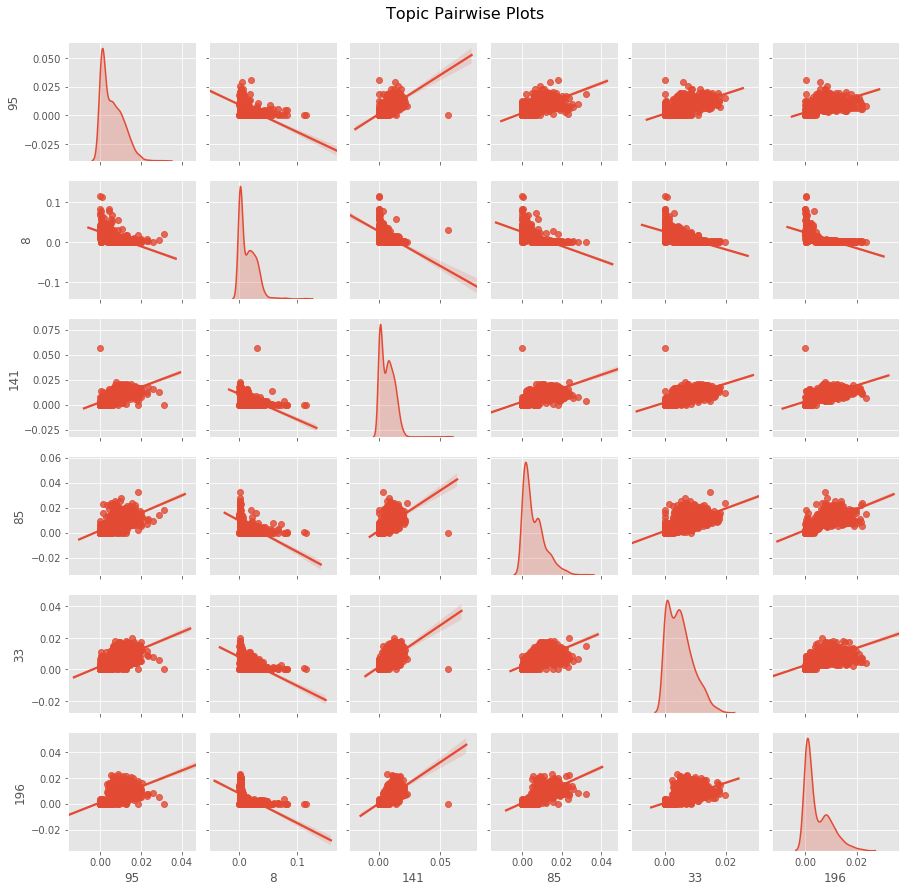

In [ ]:
g = sns.pairplot(df[topic_list], 
                 diag_kws=dict(shade=True), # "diag" adjusts/tunes the diagonal plots
                 diag_kind="kde",           # use "kde" for diagonal plots
                 height=2.1,
                 aspect=1,
                 kind="reg")                # linear regression to the scatter plots

fig = g.fig 
fig.subplots_adjust(top=0.94, wspace=0.1)
fig.suptitle('Topic Pairwise Plots', fontsize=16)

## 5 Linear Regression

**From above plot we see the negative correlations are ambiguous, while positive correlations are strong. We select one pair of them to perform a very simple linear regression.**

In [ ]:
#pair = [int(x) for x in list(df_corr_p.iloc[0][0:2])]
pair = list(df_corr_p.iloc[0][0:2])
print('Topics pair to perform linear regression:', pair)

Topics pair to perform linear regression: ['0', '174']


In [ ]:
df_topics[df_topics['topic'].isin(pair)].head()

,topic,weight,keywords
0,0,0.00194,theatre tonight exhibition universal approved adults censor recommended comedy tomorrow night plans dance george dan...
174,174,0.00176,street post sell ring opp wellington furniture wanted sale reward radio prices good lost terms ost manners_street su...


In [ ]:
x = (df.iloc[:, int(pair[0])].values).reshape(-1, 1)
y = df.iloc[:, int(pair[1])].values

In [ ]:
# gen dataset
x = (df.loc[:, pair[0]].values).reshape(-1, 1)
y = df.loc[:, pair[1]].values

# Split the dataset into the training set and test set
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.25, random_state = 1)

# model
lr = LinearRegression()

# training
lr.fit(xTrain, yTrain)

# predicting
yPred = lr.predict(xTest)

# The coefficients
print('Coefficients: \n', lr.coef_)

# The mean squared error
print("Mean squared error: {:.2f}".format(mean_squared_error(yTest, yPred)))

# Explained variance score: 1 is perfect prediction
print('Variance score: {:.2f}'.format(r2_score(yTest, yPred)))

Coefficients: 
 [0.58355785]
Mean squared error: 0.00
Variance score: 0.80


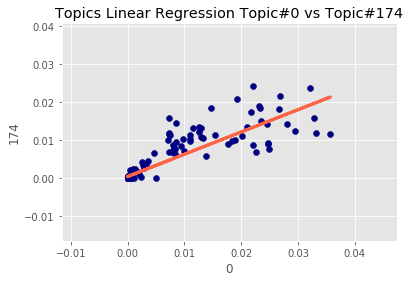

In [ ]:
# Plot outputs
plt.scatter(xTest, yTest,  color='navy')
plt.plot(xTest, yPred, color='tomato', linewidth=3)

plt.grid(True)
plt.title('Topics Linear Regression Topic#{} vs Topic#{}'.format(pair[0], pair[1]))
plt.xlabel(pair[0])
plt.ylabel(pair[1])
plt.show()

**Here we use the simple linear regression to find correlation between topics, the result is not as good as expected, for example, we see from "Average Weight Topic Over Year" plot there is positive correlation between topic 44 and topic 100, and negative correlation between topic 24 and topic 44, during a specific range of year, but we can not detect it using simple linear regression. There are many other more effective methods to anaylize correlation, such as time series Pearson correlation, we take it as future work by now.**

**The range of time may affect the regression a lot, in specific period time the correlation between topics may appear stronger than the whole time range.**

**By applying regression on topics, we can evaluate the relationship between topics quantitively, and have more change to find interesting patterns or features in topics.**

---

In [ ]:
gc.collect()